# Validation - Summary of the results

This notebook summarizes the results (e.g., generates tables, plots)

## Imports

In [145]:
library(dplyr)
require(xlsx)
require(BaylorEdPsych)
require(effsize)
library(knitr)
library(kableExtra)
library(tidyr)
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


## Load data

In [2]:
marp0 <- read.csv(file="./output/validation-marp0.csv", header=TRUE,stringsAsFactors=FALSE, row.names=1)[1,1]

In [11]:
auc_res <- read.xlsx(file='./output/validation-auc.xlsx', sheetIndex = 1)

In [47]:
aucg_res <- read.csv(file='./output/validation-aucg.csv')

In [56]:
bnucg_res <- read.csv(file='./output/validation-bnucg.csv')

In [15]:
deep_wiki300_res <- read.xlsx('./output/validation-deep-cosmic-uc-wiki300.xlsx', sheetIndex=1)

In [17]:
deep_cc42b_res <- read.xlsx('./output/validation-deep-cosmic-uc-cc42b.xlsx', sheetIndex=1)

In [18]:
deep_cc840b_res <- read.xlsx('./output/validation-deep-cosmic-uc-cc840b.xlsx', sheetIndex=1)

In [19]:
deep_se200_res <- read.xlsx('./output/validation-deep-cosmic-uc-se200.xlsx', sheetIndex=1)

In [61]:
model_names <- c('AUC', 'AUCG', 'BN-UCGAIN', 'DEEP-COSMIC-UC (Common Crawl 840B)', 
                 'DEEP-COSMIC-UC (Common Crawl 42B)', 'DEEP-COSMIC-UC (Stack Overflow)', 
                 'DEEP-COSMIC-UC (Wikipedia+Gigaworld)')
pred_results <- list(auc_res, aucg_res, bnucg_res, deep_cc840b_res, deep_cc42b_res, deep_se200_res, deep_wiki300_res)


## Helpers

In [21]:
# MAR mean absolute residual
# vector of ARs
mar <- function(ars){
  ars <- as.vector(ars)
  mar <- sum(ars) / length(ars)
  return(mar)
}

sa <- function(mar, mar_P0){
  sa <- (1 - (mar / mar_P0)) * 100
  return(sa)
}

glass_effect_size <- function(mar, mar_P0, s_P0){
  glass_effect_size <- (mar-mar_P0) / s_P0
  return(glass_effect_size)
}

heges_g_effect_size <- function(ar, ar_P0){
  heges_g_effect_size <- as.numeric(HedgesG.rawData(ar,ar_P0))
  return(heges_g_effect_size)
}

cliffs_delta_effect_size <- function(ar, ar_P0){
  cliffs_delta_effect_size <- as.numeric(cliff.delta(ar,ar_P0, return.dm=F)$estimate) 
  return(cliffs_delta_effect_size)
}

## Improvement over Random Guessing

In [62]:
improvement_random <- c()
for (pred_res in pred_results){
    improvement_random <- c(improvement_random, sa(mean(pred_res$ar), marp0))
}

In [63]:
improvement_random_df <- data.frame(model_names, improvement_random)
improvement_random_df

model_names,improvement_random
<fct>,<dbl>
AUC,25.63920
AUCG,38.44964
BN-UCGAIN,40.83139
DEEP-COSMIC-UC (Common Crawl 840B),45.01598
DEEP-COSMIC-UC (Common Crawl 42B),44.70470
DEEP-COSMIC-UC (Stack Overflow),43.56393
DEEP-COSMIC-UC (Wikipedia+Gigaworld),45.32951


## Statistical inference testing

Let's start with checking the normality assumption

In [64]:
shapiro.test(deep_wiki300_res$ar)["p.value"]

$p.value
[1] 3.967676e-67

In [65]:
shapiro.test(auc_res$ar)["p.value"]

$p.value
[1] 5.244533e-63

In [66]:
shapiro.test(aucg_res$ar)["p.value"]

$p.value
[1] 2.074054e-63

In [67]:
shapiro.test(bnucg_res$ar)["p.value"]

$p.value
[1] 5.57701e-65

There is a strong evidence against normality

In [68]:
# Is DEEP-COSMIC-UC better than AUC?
wilcox.test(deep_wiki300_res$ar, auc_res$ar, paired=T, alternative="less")["p.value"]

$p.value
[1] 1.341329e-168

In [69]:
# Is DEEP-COSMIC-UC better than AUCG?
wilcox.test(deep_wiki300_res$ar, aucg_res$ar, paired=T, alternative="less")["p.value"]

$p.value
[1] 1.688866e-39

In [70]:
# Is DEEP-COSMIC-UC better than BN-UCGAIN?
wilcox.test(deep_wiki300_res$ar, bnucg_res$ar, paired=T, alternative="less")["p.value"]

$p.value
[1] 8.064853e-22

## Cliff's delta

In [71]:
cliffs_delta_effect_size(deep_wiki300_res$ar, auc_res$ar)

[1] -0.301516

In [72]:
cliffs_delta_effect_size(deep_wiki300_res$ar, aucg_res$ar)

[1] -0.1477266

In [73]:
cliffs_delta_effect_size(deep_wiki300_res$ar, bnucg_res$ar)

[1] -0.1003021

## NNT

In [75]:
1/abs(cliffs_delta_effect_size(deep_wiki300_res$ar, auc_res$ar))

[1] 3.316574

In [76]:
1/abs(cliffs_delta_effect_size(deep_wiki300_res$ar, aucg_res$ar))

[1] 6.769262

In [77]:
1/abs(cliffs_delta_effect_size(deep_wiki300_res$ar, bnucg_res$ar))

[1] 9.969877

## Delta SA

In [197]:
sa(mean(deep_wiki300_res$ar), marp0) -  sa(mean(auc_res$ar), marp0)

[1] 19.69

In [198]:
sa(mean(deep_wiki300_res$ar), marp0) -  sa(mean(aucg_res$ar), marp0)

[1] 6.88

In [199]:
sa(mean(deep_wiki300_res$ar), marp0) -  sa(mean(bnucg_res$ar), marp0)

[1] 4.498

## MAR

In [78]:
mar <- c()
for (pred_res in pred_results){
    mar <- c(mar, mean(pred_res$ar))
}

## MdAR

In [79]:
mdar <- c()
for (pred_res in pred_results){
    mdar <- c(mdar, median(pred_res$ar))
}

## Accuracy summary table

In [80]:
acc_summary_df <- data.frame(Model=model_names, SA=improvement_random, MAR=mar, MdAR=mdar)

In [130]:
options(digits=4)
acc_summary_df

Model,SA,MAR,MdAR
<fct>,<dbl>,<dbl>,<dbl>
AUC,25.64,4.732,3.794
AUCG,38.45,3.917,2.894
BN-UCGAIN,40.83,3.766,2.765
DEEP-COSMIC-UC (Common Crawl 840B),45.02,3.499,2.284
DEEP-COSMIC-UC (Common Crawl 42B),44.70,3.519,2.265
DEEP-COSMIC-UC (Stack Overflow),43.56,3.592,2.337
DEEP-COSMIC-UC (Wikipedia+Gigaworld),45.33,3.479,2.204


In [127]:
digits <- options()['digits']
options(digits=4)
kable(acc_summary_df, "latex", booktabs=T)
options(digits=digits$digits)


\begin{tabular}{lrrr}
\toprule
Model & SA & MAR & MdAR\\
\midrule
AUC & 25.64 & 4.732 & 3.794\\
AUCG & 38.45 & 3.917 & 2.894\\
BN-UCGAIN & 40.83 & 3.765 & 2.765\\
DEEP-COSMIC-UC (Common Crawl 840B) & 45.02 & 3.499 & 2.284\\
DEEP-COSMIC-UC (Common Crawl 42B) & 44.70 & 3.519 & 2.265\\
\addlinespace
DEEP-COSMIC-UC (Stack Overflow) & 43.56 & 3.592 & 2.337\\
DEEP-COSMIC-UC (Wikipedia+Gigaworld) & 45.33 & 3.479 & 2.204\\
\bottomrule
\end{tabular}

## Residual box-plots

In [132]:
ars_df <- NULL
for (pred_res in pred_results){
    if (is.null(ars_df)){
        ars_df <- data.frame( pred_res$ar)
    }else{
       ars_df <- cbind(ars_df, pred_res$ar)
    }
}
colnames(ars_df) <- model_names

In [142]:
ars_long_df <- gather(ars_df)
colnames(ars_long_df) <- c('Model', 'AE')

Warning message:
"Ignoring unknown parameters: outlier.colour, outlier.shape, notch"Warning message:
"`show_guide` has been deprecated. Please use `show.legend` instead."Warning message:
"`show_guide` has been deprecated. Please use `show.legend` instead."Warning message:
"Removed 20 rows containing missing values (geom_point)."Warning message:
"Removed 17 rows containing missing values (geom_point)."

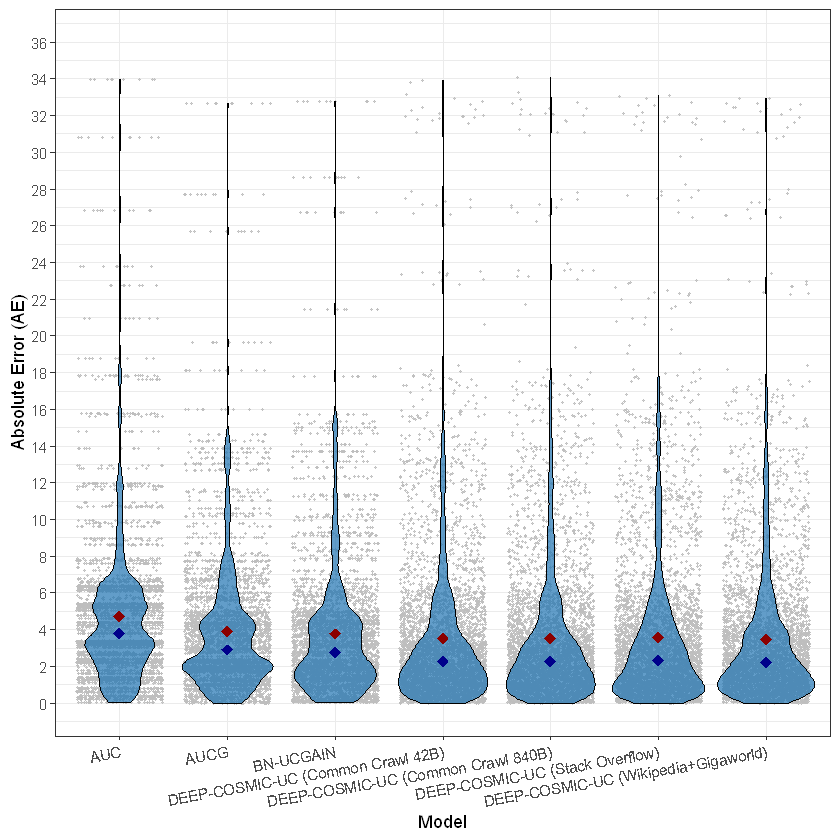

In [196]:
ggplot(ars_long_df, aes(x=Model, y=AE)) +
scale_x_discrete(name = "Model") +
scale_y_continuous(name = "Absolute Error (AE)", breaks = seq(0, 36, 2), limits=c(0, 36)) +
geom_jitter(size=0.5, colour='gray', alpha=0.8) +
geom_violin(fill = "#1f74b2", colour = "black", outlier.colour = "black", outlier.shape = 20, alpha=0.7, notch = F)  + 
stat_summary(fun.y=mean, colour="darkred", geom="point", 
               shape=18, size=3,show_guide = FALSE) + 
stat_summary(fun.y=median, colour="darkblue", geom="point", 
               shape=18, size=3,show_guide = FALSE) + 
theme_bw() + 
theme(axis.text.x = element_text(angle = 10, hjust = 1))
#coord_flip()

ggsave('./output/ae-plot.pdf', plot = last_plot(), 
  scale = 1, width = 10, height = 4, units = 'in',
  dpi = 300,)
 

## Use cases with the highest MAE

In [216]:
head(deep_wiki300_res %>% group_by(UC, ProjectID) %>% summarise(mae=mean(ar)) %>% arrange(desc(mae)), 10)

UC,ProjectID,mae
<fct>,<fct>,<dbl>
PU-SCMS-ZK-10,P03,32.23
UC2-5-4,P01,31.88
UC2-2-11,P01,27.06
UC2-3-7,P01,22.74
WF-SCMS2-MCP-ADM-7,P04,17.08
PU-SCMS-ZK-19,P03,16.88
UC2-3-4,P01,16.55
AP_UC1,P20,16.10
Pwd,P26,15.66


## MAE without 5% outliers

In [221]:
most_outlying_uc_df <- head(deep_wiki300_res %>% group_by(UC, ProjectID) %>% summarise(mae=mean(ar)) %>% arrange(desc(mae)), 21)

In [222]:
mar_out <- c()
for (pred_res in pred_results){
    mar_out <- c(mar_out, mean((pred_res %>% filter(!(UC %in% most_outlying_uc_df$UC), !(ProjectID %in% most_outlying_uc_df$ProjectID)))$ar))
}
data.frame(Model=model_names,  MAR=mar_out)

Model,MAR
<fct>,<dbl>
AUC,3.782
AUCG,3.019
BN-UCGAIN,2.847
DEEP-COSMIC-UC (Common Crawl 840B),2.450
DEEP-COSMIC-UC (Common Crawl 42B),2.512
DEEP-COSMIC-UC (Stack Overflow),2.562
DEEP-COSMIC-UC (Wikipedia+Gigaworld),2.387
